# Gammapy workshop - 3-4 december 2024

## Tutorial overview

This notebook shows how to

- load observation runs and select data
- fit a source model
- make maps
- make an energy spectrum

Here we will use the public HESS data

This tutorial makes use of the gamapy documentation and tutorials (https://docs.gammapy.org/1.2/tutorials/index.html)

## Prerequisite

Download the gammapy dataset and declare GAMMAPY_DATA as a global env variable: 

`$ gammapy download datasets`

`$ export GAMMAPY_DATA=$PWD/gammapy-datasets/1.2`

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
import astropy.units as u
from gammapy.maps import Map
from gammapy.maps import MapAxis, WcsGeom #, RegionGeom, 
from gammapy.datasets import MapDataset#, Datasets, FluxPointsDataset, SpectrumDataset
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker, RingBackgroundMaker
from gammapy.data import DataStore
from gammapy.modeling.models import (
    FoVBackgroundModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
)
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator, ExcessMapEstimator, TSMapEstimator
from gammapy.catalog import SourceCatalogGammaCat

## Load Data

Create a datastore from the directory containing HESS dl3 data. There are 2 tables in this data store : an HDU index table and an observation table.

In [2]:
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")

In [3]:
datastore

In [4]:
datastore.hdu_table[:10]

<HDUIndexTable length=10>
OBS_ID HDU_TYPE HDU_CLASS FILE_DIR             FILE_NAME              HDU_NAME  SIZE 
int64   bytes6    bytes9   bytes4               bytes34                bytes6  int64 
------ -------- --------- -------- ---------------------------------- -------- ------
 20136     aeff   aeff_2d     data hess_dl3_dr1_obs_id_020136.fits.gz     aeff  11520
 20136      bkg    bkg_3d     data hess_dl3_dr1_obs_id_020136.fits.gz      bkg 207360
 20136    edisp  edisp_2d     data hess_dl3_dr1_obs_id_020136.fits.gz    edisp 377280
 20136   events    events     data hess_dl3_dr1_obs_id_020136.fits.gz   events 414720
 20136      gti       gti     data hess_dl3_dr1_obs_id_020136.fits.gz      gti   5760
 20136      psf psf_table     data hess_dl3_dr1_obs_id_020136.fits.gz      psf 118080
 20137     aeff   aeff_2d     data hess_dl3_dr1_obs_id_020137.fits.gz     aeff  11520
 20137      bkg    bkg_3d     data hess_dl3_dr1_obs_id_020137.fits.gz      bkg 207360
 20137    edisp  edisp_2d     data hess_dl3_dr1_obs_id_020137.fits.gz    edisp 377280
 20137   events    events     data hess_dl3_dr1_obs_id_020137.fits.gz   events 216000

In [5]:
datastore.obs_table[:10]

<ObservationTable length=10>
OBS_ID   RA_PNT   DEC_PNT    GLON_PNT  GLAT_PNT   ZEN_PNT  ... EVENT_COUNT TARGET_NAME TARGET_TAG TARGET_OFFSET SAFE_ENERGY_LO SAFE_ENERGY_HI
          deg       deg        deg       deg        deg    ...                                         deg           TeV            TeV      
int64   float32   float32    float32   float32    float32  ...    int64      bytes21    bytes14      float32       float32        float32    
------ --------- ---------- --------- ---------- --------- ... ----------- ----------- ---------- ------------- -------------- --------------
 20136  228.6125 -58.771667 320.56754 -0.8857012 38.512962 ...       11243   MSH 15-52    msh1552    0.38821736     0.40738028          100.0
 20137  228.6125 -59.771667 320.04724 -1.7397733  40.21616 ...        5693   MSH 15-52    msh1552     0.6156251     0.40738028          100.0
 20151  228.6125 -58.771667 320.56754 -0.8857012 37.164658 ...       10722   MSH 15-52    msh1552    0.38821736     0.40738028          100.0
 20275 187.27792   2.552389  289.7155  64.849686  36.18243 ...       10646    Off data    offdata            --     0.33113113          100.0
 20282  228.6125 -58.771667 320.56754 -0.8857012  37.13134 ...       11063   MSH 15-52    msh1552    0.38821736     0.40738028          100.0
 20283  228.6125 -59.771667 320.04724 -1.7397733 36.221436 ...        7628   MSH 15-52    msh1552     0.6156251      0.3801894          100.0
 20301  228.6125 -58.771667 320.56754 -0.8857012 36.839905 ...       11624   MSH 15-52    msh1552    0.38821736     0.40738028          100.0
 20302  228.6125 -59.771667 320.04724 -1.7397733  36.11632 ...       11794   MSH 15-52    msh1552     0.6156251      0.3801894          100.0
 20303  228.6125 -58.771667 320.56754 -0.8857012 36.186012 ...       11803   MSH 15-52    msh1552    0.38821736      0.3801894          100.0
 20322  228.6125 -59.771667 320.04724 -1.7397733 36.913094 ...       12925   MSH 15-52    msh1552     0.6156251     0.40738028          100.0

Selection using the target name :

In [6]:
target_name = "Crab Nebula"
selection_mask = datastore.obs_table["OBJECT"]==target_name
selected_obs_table = datastore.obs_table[selection_mask]

In [7]:
selected_obs_table

<ObservationTable length=4>
OBS_ID   RA_PNT   DEC_PNT   GLON_PNT  GLAT_PNT   ZEN_PNT  ... EVENT_COUNT TARGET_NAME TARGET_TAG TARGET_OFFSET SAFE_ENERGY_LO SAFE_ENERGY_HI
          deg       deg       deg       deg        deg    ...                                         deg           TeV            TeV      
int64   float32   float32   float32   float32    float32  ...    int64      bytes21    bytes14      float32       float32        float32    
------ --------- --------- --------- ---------- --------- ... ----------- ----------- ---------- ------------- -------------- --------------
 23523  83.63333 21.514444  184.9823 -6.0516925  48.61021 ...        7613        Crab       crab      0.500049      0.8709636          100.0
 23526  83.63333 22.514444 184.13332 -5.5163794  45.77929 ...        7581        Crab       crab    0.49995112     0.70794576          100.0
 23559 85.253334 22.014444 185.35727  -4.510869 45.368176 ...        7601        Crab       crab     1.5021166     0.66069347          100.0
 23592 82.013336 22.014444  183.7408  -7.047852 48.389248 ...        7334        Crab       crab     1.5016365      0.8709636          100.0

Selection using the position :

In [8]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon="83.633 deg",
    lat="22.014 deg",
    radius="5 deg",
)
selected_obs_table = datastore.obs_table.select_observations(selection)

In [9]:
selected_obs_table

<ObservationTable length=4>
OBS_ID   RA_PNT   DEC_PNT   GLON_PNT  GLAT_PNT   ZEN_PNT  ... EVENT_COUNT TARGET_NAME TARGET_TAG TARGET_OFFSET SAFE_ENERGY_LO SAFE_ENERGY_HI
          deg       deg       deg       deg        deg    ...                                         deg           TeV            TeV      
int64   float32   float32   float32   float32    float32  ...    int64      bytes21    bytes14      float32       float32        float32    
------ --------- --------- --------- ---------- --------- ... ----------- ----------- ---------- ------------- -------------- --------------
 23523  83.63333 21.514444  184.9823 -6.0516925  48.61021 ...        7613        Crab       crab      0.500049      0.8709636          100.0
 23526  83.63333 22.514444 184.13332 -5.5163794  45.77929 ...        7581        Crab       crab    0.49995112     0.70794576          100.0
 23559 85.253334 22.014444 185.35727  -4.510869 45.368176 ...        7601        Crab       crab     1.5021166     0.66069347          100.0
 23592 82.013336 22.014444  183.7408  -7.047852 48.389248 ...        7334        Crab       crab     1.5016365      0.8709636          100.0

Fetch observations from the data store using `get_observations`

In [10]:
observations = datastore.get_observations(selected_obs_table["OBS_ID"])

In [11]:
print(observations)

Observations
Number of observations: 4
Observation

	obs id            : 23523 
 	tstart            : 53343.92
	tstop             : 53343.94
	duration          : 1687.00 s
	pointing (icrs)   : 83.6 deg, 21.5 deg

	deadtime fraction : 6.2%
Observation

	obs id            : 23526 
 	tstart            : 53343.95
	tstop             : 53343.97
	duration          : 1683.00 s
	pointing (icrs)   : 83.6 deg, 22.5 deg

	deadtime fraction : 6.6%
Observation

	obs id            : 23559 
 	tstart            : 53345.96
	tstop             : 53345.98
	duration          : 1686.00 s
	pointing (icrs)   : 85.3 deg, 22.0 deg

	deadtime fraction : 6.4%
Observation

	obs id            : 23592 
 	tstart            : 53347.91
	tstop             : 53347.93
	duration          : 1686.00 s
	pointing (icrs)   : 82.0 deg, 22.0 deg

	deadtime fraction : 6.2%



In [12]:
print(observations[0])

Observation

	obs id            : 23523 
 	tstart            : 53343.92
	tstop             : 53343.94
	duration          : 1687.00 s
	pointing (icrs)   : 83.6 deg, 21.5 deg

	deadtime fraction : 6.2%



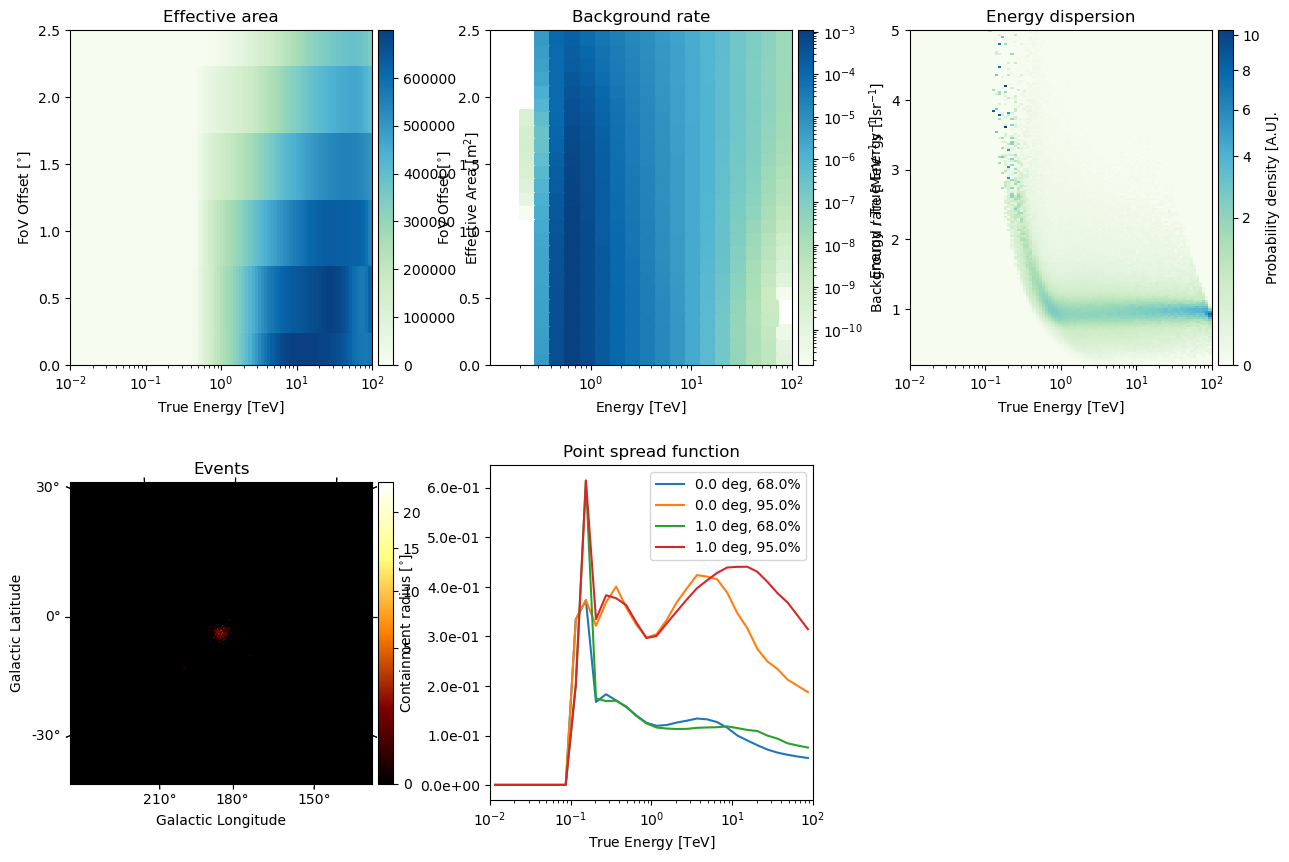

In [13]:
observations[0].peek()

In [14]:
print(observations[0].events)

EventList
---------

  Instrument       : H.E.S.S. Phase I
  Telescope        : HESS
  Obs. ID          : 23523

  Number of events : 7613
  Event rate       : 4.513 1 / s

  Time start       : 53343.92234009259
  Time stop        : 53343.94186555556

  Min. energy      : 2.44e-01 TeV
  Max. energy      : 1.01e+02 TeV
  Median energy    : 9.53e-01 TeV

  Max. offset      : 58.0 deg



## Preparing dataset geometry

In [15]:
energy_reco = MapAxis.from_energy_bounds(
    0.5,
    50,
    nbin=10,
    unit="TeV",
    name="energy",
)

energy_true = MapAxis.from_energy_bounds(
    0.1,
    80,
    nbin=20,
    unit="TeV",
    name="energy_true",
)

geom = WcsGeom.create(
    skydir=(83.633, 22.014), 
    width=(6, 6), 
    binsz=0.02, 
    frame="icrs", 
    axes=[energy_reco]
)

print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (300, 300, 10)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 6.0 deg x 6.0 deg
	wcs ref    : 83.6 deg, 22.0 deg



Create a `MapDataset` containing zero filled maps.

In [16]:
stacked = MapDataset.create(geom=geom, energy_axis_true=energy_true, name="crab-stacked")
print(stacked)

MapDataset
----------

  Name                            : crab-stacked 

  Total counts                    : 0 
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.00
  Predicted background counts     : 0.00
  Predicted excess counts         : nan

  Exposure min                    : 0.00e+00 m2 s
  Exposure max                    : 0.00e+00 m2 s

  Number of total bins            : 900000 
  Number of fit bins              : 0 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




## Data reduction

#### Exclusion mask for known sources

<WCSAxes: >

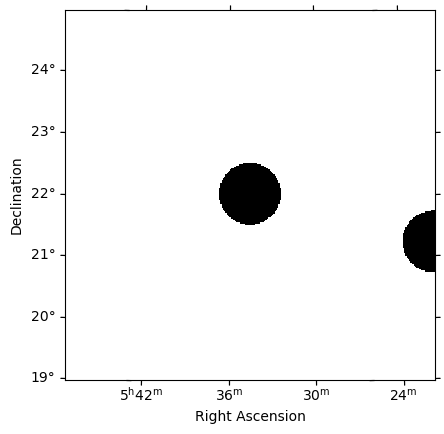

In [17]:
exclusion_radius = 0.5*u.deg

crab_position = SkyCoord.from_name("Crab Nebula").icrs
crab_exclusion = CircleSkyRegion(center=crab_position, radius=exclusion_radius)

#crab_position = SkyCoord(83.633083, 22.0145, unit="deg", frame="icrs")
#crab_exclusion = CircleSkyRegion(center=crab_position, radius=exclusion_radius)

RGBJ0521_position = SkyCoord.from_name("RGB J0521+212").galactic
RGBJ0521_exclusion = CircleSkyRegion(center=RGBJ0521_position, radius=exclusion_radius)

exclusion_mask = ~geom.region_mask(regions=[crab_exclusion, RGBJ0521_exclusion])
exclusion_mask.sum_over_axes().plot()

In [18]:
maker = MapDatasetMaker(selection=["counts", "background", "exposure", "psf"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max", "aeff-max", "bkg-peak"], offset_max=2.5 * u.deg)
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

In [19]:
print(maker_safe_mask)

SafeMaskMaker
-------------

  methods      : {'offset-max', 'aeff-max', 'bkg-peak'}
  aeff_percent : 10
  bias_percent : 10
  offset_max   : 2.5 deg
  irfs         : DL4



In [20]:
for obs in observations:
    cutout = stacked.cutout(obs.get_pointing_icrs(obs.tmid), width="5 deg") # cutout of the target map is produced
    dataset = maker.run(cutout, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset = maker_fov.run(dataset)
    stacked.stack(dataset)

In [21]:
print(stacked)

MapDataset
----------

  Name                            : crab-stacked 

  Total counts                    : 16978 
  Total background counts         : 16045.09
  Total excess counts             : 932.91

  Predicted counts                : 16045.08
  Predicted background counts     : 16045.09
  Predicted excess counts         : nan

  Exposure min                    : 1.03e+06 m2 s
  Exposure max                    : 3.61e+09 m2 s

  Number of total bins            : 900000 
  Number of fit bins              : 761040 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




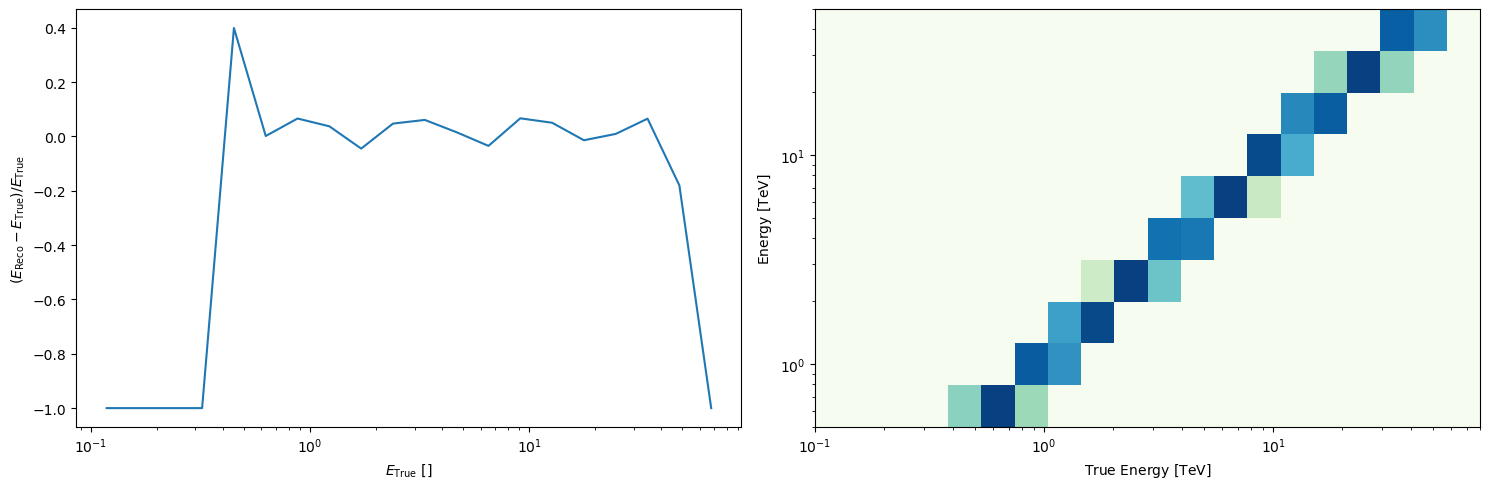

In [22]:
stacked.edisp.peek()

#### Plot maps

<WCSAxes: >

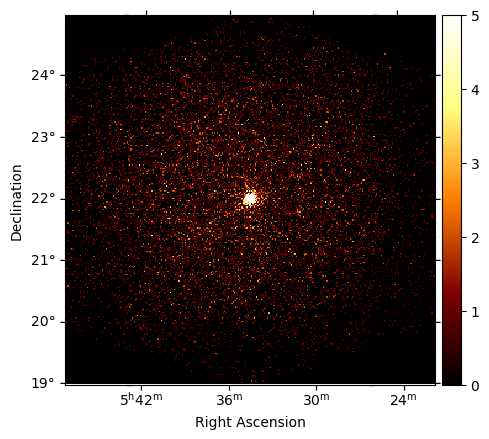

In [23]:
stacked.counts.sum_over_axes().plot(add_cbar=True, stretch="linear", vmax=5)

<WCSAxes: >

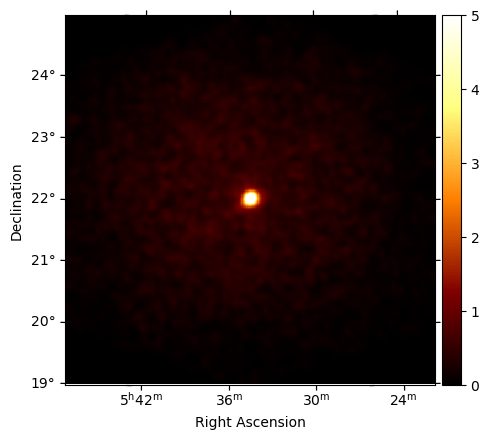

In [24]:
stacked.counts.sum_over_axes().smooth(0.05*u.deg).plot(add_cbar=True, stretch="linear", vmax=5)

<WCSAxes: >

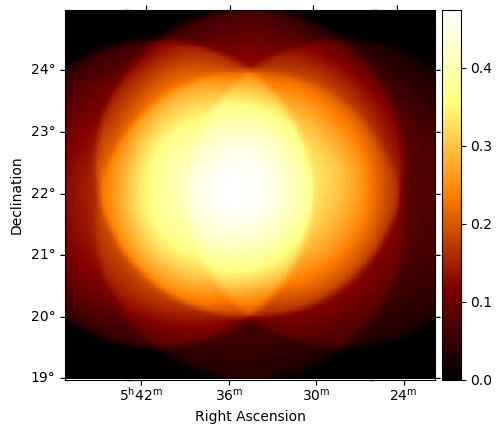

In [25]:
stacked.background.smooth(0.05 * u.deg).sum_over_axes().plot(add_cbar=True, stretch="linear")

<WCSAxes: >

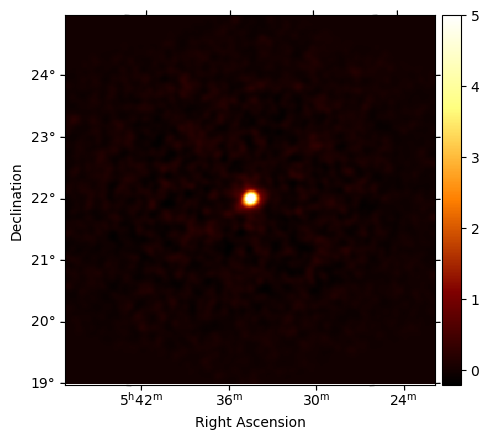

In [26]:
stacked.excess.smooth(0.05 * u.deg).sum_over_axes().plot(add_cbar=True, stretch="linear", vmax=5)

### Make a significance map

<WCSAxes: >

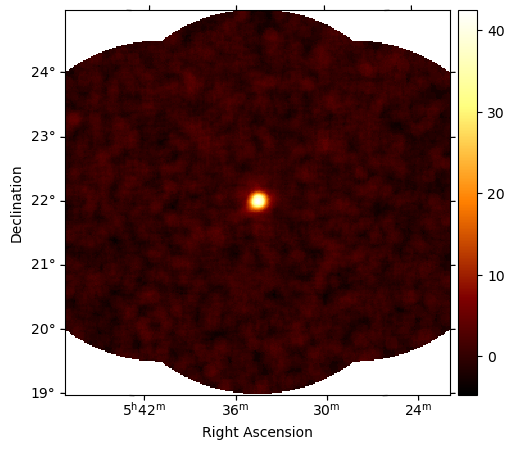

In [28]:
# Using LiMa
# Reference paper : https://articles.adsabs.harvard.edu/pdf/1983ApJ...272..317L
estimator = ExcessMapEstimator(correlation_radius=0.1 * u.deg)
maps = estimator.run(stacked)
fig = plt.figure(figsize=(5.5, 5))
ax = plt.subplot(111, projection=maps.geom.wcs)
sig_map = maps["sqrt_ts"]
sig_map.plot(ax=ax, stretch="linear", add_cbar=True)

In [29]:
# Using a model

spatial_model_TS = GaussianSpatialModel(sigma=0.06*u.deg)
spectral_model_TS = PowerLawSpectralModel(amplitude="1e-13 cm-2 s-1 TeV-1", index=2.5)
model_TS = SkyModel(spatial_model=spatial_model_TS, spectral_model=spectral_model_TS)

estimator = TSMapEstimator(model_TS)
maps = estimator.run(stacked)
sig_map = maps["sqrt_ts"]

<WCSAxes: >

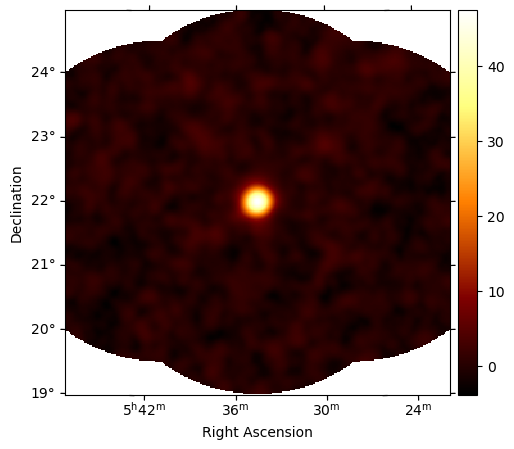

In [31]:
fig = plt.figure(figsize=(5.5, 5))
ax = plt.subplot(111, projection=sig_map.geom.wcs)
sig_map.plot(ax=ax, stretch="linear", add_cbar=True)

#### Save dataset to disk

In [32]:
stacked.write('./crab_dataset.fits.gz', overwrite=True)

## Define and fit a model for your source

In [33]:
# Crab
target_position = SkyCoord(ra=83.63308, dec=22.01450, unit="deg")

spatial_model = PointSpatialModel(
    lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs"
)

spectral_model = PowerLawSpectralModel(
    index=2.5,
    amplitude=1e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

crab_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="crab"
)

# Bakcground
bkg_model = FoVBackgroundModel(dataset_name="crab-stacked")

In [34]:
stacked.models = [crab_model, bkg_model]
print(stacked.models)

DatasetModels

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.500   +/-    0.00             
    amplitude                     :   1.00e-11   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :     83.633   +/-    0.00 deg         
    lat_0                         :     22.015   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : crab-stacked-bkg
  Datasets names            : ['crab-stacked']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.0

In [35]:
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run([stacked])

In [36]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 188
	total stat : 134151.06

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [37]:
L = stacked.stat_sum() # stat_sum() give the total likelihood with the current parameters
print(L)

134151.0572380362


In [38]:
print(stacked.models)

DatasetModels

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.641   +/-    0.05             
    amplitude                     :   4.23e-11   +/- 1.7e-12 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :     83.618   +/-    0.00 deg         
    lat_0                         :     22.025   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : crab-stacked-bkg
  Datasets names            : ['crab-stacked']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.004   +/-    0.01             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.0

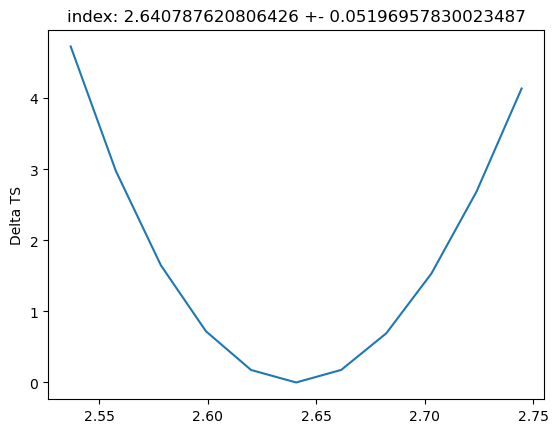

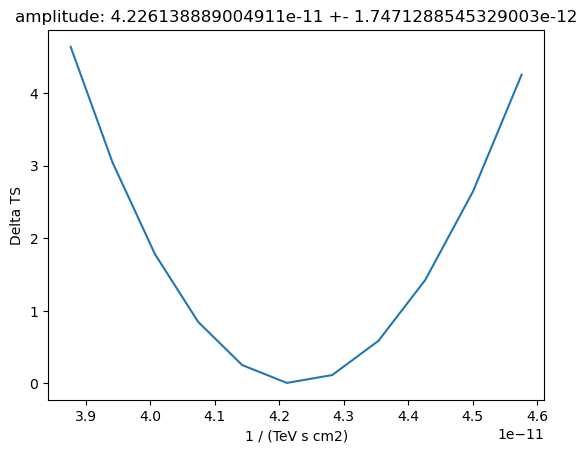

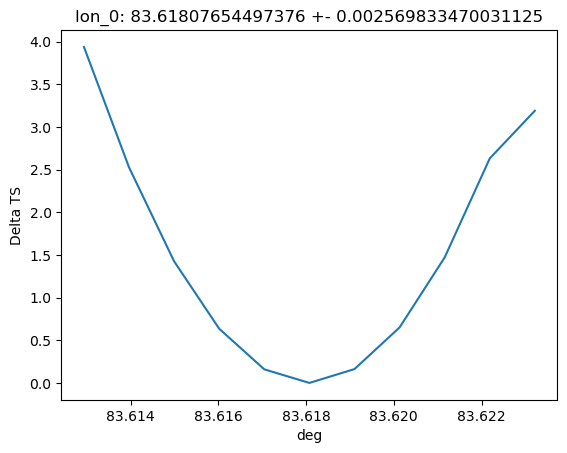

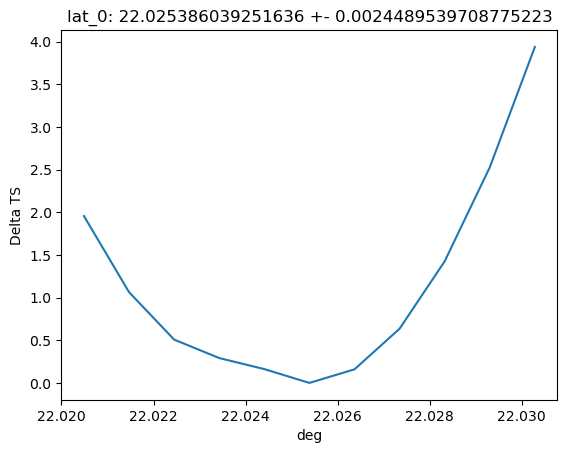

In [39]:
total_stat = result.total_stat

for par in crab_model.parameters:
    if par.frozen is False:
        profile = fit.stat_profile(stacked, parameter=par)
        
        if par.name in ('index', 'amplitude'):
            plt.plot(
                profile[f"crab.spectral.{par.name}_scan"], profile["stat_scan"] - total_stat
            )
        if par.name in ('lon_0', 'lat_0', 'sigma', 'r_0', 'eta'):
            plt.plot(
                profile[f"crab.spatial.{par.name}_scan"], profile["stat_scan"] - total_stat
            )
            
        plt.xlabel(f"{par.unit}")
        plt.ylabel("Delta TS")
        plt.title(f"{par.name}: {par.value} +- {par.error}")
        plt.show()
        plt.close()

<WCSAxes: >

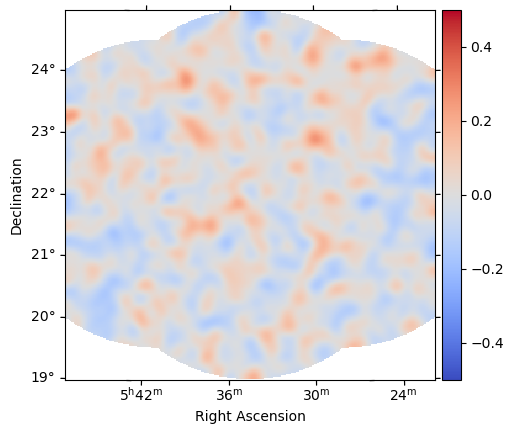

In [40]:
stacked.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)

#### Plot the spectrum

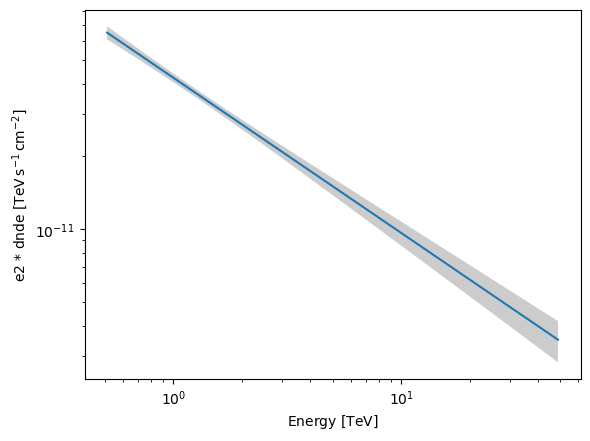

In [41]:
spec = crab_model.spectral_model

energy_bounds = [0.5, 50] * u.TeV
spec.plot(energy_bounds=energy_bounds, energy_power=2)
ax = spec.plot_error(energy_bounds=energy_bounds, energy_power=2)


#### Compute flux points

In [42]:
#energy_edges = [1, 2, 4, 10] * u.TeV
E_min = 0.5
E_max = 50
nbins = 10

energy_edges = MapAxis.from_energy_bounds(E_min,E_max,nbins,unit="TeV").edges

fpe = FluxPointsEstimator(energy_edges=energy_edges, source="crab")

(1e-13, 3e-10)

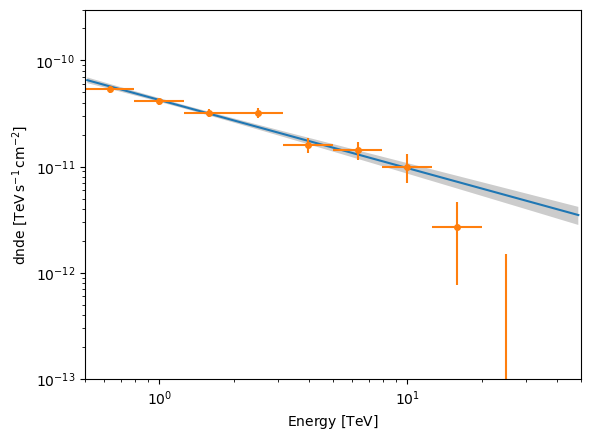

In [43]:
flux_points = fpe.run(datasets=[stacked])

spec.plot(energy_bounds=energy_bounds, energy_power=2)
ax = spec.plot_error(energy_bounds=energy_bounds, energy_power=2)

flux_points.plot(ax=ax, energy_power=2)
ax.set_ylim(1e-13,3e-10)